# JSMP: Ensemble Selection

This was done with just 1-2 days to go until the deadline, so it was quite rushed and ad hoc, but I feel I achieved sufficient diversity in the ensemble members to build a robust final submission. Only time will tell!

In [1]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jsmp
jsmp.env_config("config.json")

Value for DATA_DIR has been set!


## Setup

### File paths

In [2]:
comp_dir = os.path.join(os.environ.get("DATA_DIR"), "jane-street-market-prediction")
model_dir = os.path.join(comp_dir, "models_CV_Kaggle")
esmbl_dir = os.path.join(comp_dir, "final_ensemble")

### K-Fold performance stats

Concatenate all the K-fold performance summaries of all the models to compare:

In [3]:
df_list = []
for f in os.listdir(model_dir):
    if f.endswith(".csv"):
        cv_df = pd.read_csv(os.path.join(model_dir, f))
        cv_df.loc[:, 'model'] = f[:16]
        df_list.append(cv_df)
df = pd.concat(df_list)
df

,profit,volatility,ratio,utility,threshold,kfold,resp_mean,resp_median,resp_std,wgt_median,model
0,458.943415,128.152129,3.581239,1643.586109,T_50,K1,0.000521,0.000100,0.027996,1.069874,D20210220_100224
1,304.485367,137.261435,2.218288,675.436177,T_50,K2,0.000252,0.000059,0.028308,1.079640,D20210220_100224
2,230.828170,103.488263,2.230477,514.856877,T_50,K3,0.000363,0.000093,0.027199,1.090258,D20210220_100224
3,346.579221,118.158690,2.933167,1016.574882,T_50,K4,0.000379,0.000115,0.028686,1.059292,D20210220_100224
4,539.866528,94.761797,5.697090,3075.668446,T_50,K5,0.000845,0.000115,0.028555,1.066722,D20210220_100224
...,...,...,...,...,...,...,...,...,...,...,...
15,466.476977,113.654715,4.104335,1914.577588,T_95,K1,0.000521,0.000100,0.027996,1.069874,D20210222_013051
16,296.449349,136.102482,2.178133,645.706199,T_95,K2,0.000252,0.000059,0.028308,1.079640,D20210222_013051
17,215.598596,99.690224,2.162685,466.271944,T_95,K3,0.000363,0.000093,0.027199,1.090258,D20210222_013051
18,363.297813,109.323208,3.323154,1207.294433,T_95,K4,0.000379,0.000115,0.028686,1.059292,D20210222_013051


### Performance summary across all folds

For a given model and action threshold level, across all 5 folds:
* Compute the average utility
* Compute the standard deviation of utility
* Compute the ratio of the 2

In [4]:
grp_cols = ['model', 'threshold']

# avg utility and its st. dev. accross folds
avg_u_df = df.groupby(grp_cols)[['utility']].mean().rename(columns={'utility': 'u_mean'}).reset_index()
std_u_df = df.groupby(grp_cols)[['utility']].std().rename(columns={'utility': 'u_vol'}).reset_index()
u_df = pd.merge(avg_u_df, std_u_df, on=grp_cols)

# ratio of avg and st.dev
u_df.loc[:, 'ratio'] = u_df['u_mean'] / u_df['u_vol']

# sort and display
u_df = u_df.sort_values("u_mean", ascending=False)
u_df.head(11)

,model,threshold,u_mean,u_vol,ratio
244,D20210221_120847,T_50,1838.175178,1224.818177,1.500774
245,D20210221_120847,T_75,1789.882645,1120.052085,1.598035
246,D20210221_120847,T_90,1771.968533,1108.166973,1.599009
247,D20210221_120847,T_95,1751.335738,1041.757584,1.681136
71,D20210220_224658,T_95,1712.057158,1132.375081,1.511917
69,D20210220_224658,T_75,1699.464972,1105.041238,1.537920
70,D20210220_224658,T_90,1684.190094,1147.124681,1.468184
167,D20210221_051905,T_95,1643.697109,1096.626954,1.498866
237,D20210221_120738,T_75,1618.238731,992.400321,1.630631
239,D20210221_120738,T_95,1618.115569,929.567512,1.740719


## Selection

### Top 6 average utility

In [5]:
e1 = u_df.sort_values("u_mean", ascending=False).groupby('model').head(1).head(6)
e1

,model,threshold,u_mean,u_vol,ratio
244,D20210221_120847,T_50,1838.175178,1224.818177,1.500774
71,D20210220_224658,T_95,1712.057158,1132.375081,1.511917
167,D20210221_051905,T_95,1643.697109,1096.626954,1.498866
237,D20210221_120738,T_75,1618.238731,992.400321,1.630631
273,D20210222_002224,T_75,1611.419886,827.022180,1.948460
294,D20210222_012751,T_90,1567.649892,700.331166,2.238441


### Top 7 ratios

* Subject to more than 1500 average utility

In [6]:
e2 = u_df.sort_values("ratio", ascending=False).groupby('model').head(1).query("u_mean > 1500").head(7)
e2

,model,threshold,u_mean,u_vol,ratio
295,D20210222_012751,T_95,1524.424632,659.379491,2.311908
275,D20210222_002224,T_95,1521.300697,705.075960,2.157641
243,D20210221_120808,T_95,1526.210163,708.553198,2.153981
147,D20210221_051502,T_95,1523.955756,770.246501,1.978530
159,D20210221_051717,T_95,1539.685243,783.254019,1.965755
199,D20210221_064625,T_95,1559.600354,796.217269,1.958762
235,D20210221_100326,T_95,1531.841304,818.581063,1.871337


### Fold champions

Ignoring the threshold, I summarised the performance by each fold and picked the top model in each fold (so long the model's average utility was above 1400):

In [7]:
# fold-level average utility 
grp_cols_2 = ['model', 'kfold']
avg_u_df_2 = df.groupby(grp_cols_2)[['utility']].mean().rename(columns={'utility': 'k_mean'}).reset_index()

# overall utility performance for quality control 
avg_u_df_3 = df.groupby('model')[['utility']].mean().rename(columns={'utility': 'u_mean'}).reset_index()
std_u_df_3 = df.groupby('model')[['utility']].std().rename(columns={'utility': 'u_vol'}).reset_index()
avg_u_df_2 = avg_u_df_2.merge(avg_u_df_3, on='model').merge(std_u_df_3, on='model')

# choose the top performer in each fold so long as it meets the 1400 threshold 
e3 = avg_u_df_2.sort_values(['kfold', 'k_mean'], ascending=False).query("u_mean > 1400").groupby('kfold').head(1)
e3

,model,kfold,k_mean,u_mean,u_vol
309,D20210221_120847,K5,3576.846974,1787.840524,1033.455316
343,D20210222_002224,K4,1587.784191,1570.091340,711.827828
42,D20210220_103359,K3,880.660486,1431.264883,679.430201
171,D20210221_035856,K2,1450.412983,1485.728024,783.038377
85,D20210220_224658,K1,2473.961880,1666.167650,1032.209824


### Final ensemble

I combined all the above into one table and assigned weights to each model based on occurence frequency.
* Note I was cheeky and gave my favourite model `D20210220_100512` a bit of extra weighting :-)

In [8]:
e_hi = pd.DataFrame([{'model': 'D20210220_100512'} for i in range(2)])
e_df = pd.concat([e1[['model']], e2[['model']], e3[['model']], e_hi])
e_df = e_df.model.value_counts(normalize=True).to_frame().reset_index()
e_df.columns = ['model', 'weight']
e_df.to_csv(os.path.join(esmbl_dir, "ensemble_weights.csv"), index=False)
e_df

,model,weight
0,D20210222_002224,0.15
1,D20210222_012751,0.10
2,D20210220_224658,0.10
3,D20210221_120847,0.10
4,D20210220_100512,0.10
5,D20210221_051905,0.05
6,D20210221_064625,0.05
7,D20210221_120808,0.05
8,D20210221_120738,0.05
9,D20210221_100326,0.05


## Appendix

### Threshold picking

From the above, I couldn't really say which action threshold would be best to use, so I came up with a function of the weight. The threshold would be more conservative for higher weights:

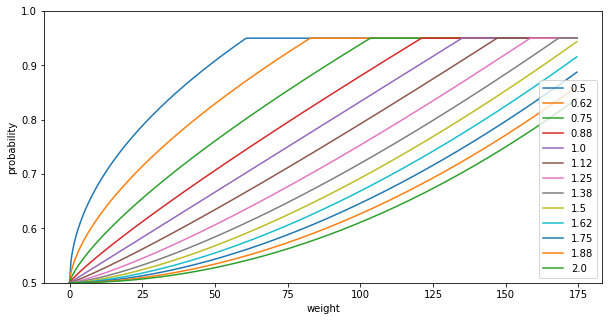

In [9]:
p_int, p_div, p_max = 0.5, 300, 0.95
x = np.arange(0, 175, 0.5)
pwrs = np.arange(0.5, 2.001, 0.125)
fig, ax = plt.subplots(figsize=(10,5))
for p in pwrs:
    p = np.round(p, 2)
    y = p_int + (x/p_div) ** p
    y = np.where(y > p_max, p_max, y)
    ax.plot(x, y, label=str(p))
plt.legend(loc="lower right")
plt.xlabel("weight")
plt.ylabel("probability")
plt.ylim(p_int, 1)
plt.show()